In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import cv2 
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
imsize = 1024 if torch.cuda.is_available() else 128  
print(imsize)

1024


In [ ]:
loader = transforms.Compose([transforms.Resize(imsize), #scaling the image
                             transforms.ToTensor()])  # #transforming image to torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0) # fake batch dimensions to fit network's input
    return image.to(device, torch.float)


    

In [ ]:
style_img = image_loader("/content/drive/MyDrive/Neural Style Transfer/renoir.jpg")
content_img = image_loader("/content/drive/MyDrive/Neural Style Transfer/khushi.jpeg")

assert style_img.size() == content_img.size()

print(style_img.size())
print(content_img.size())


torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


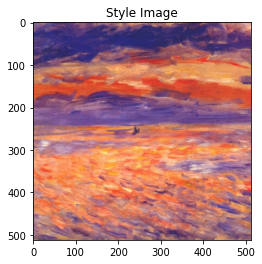

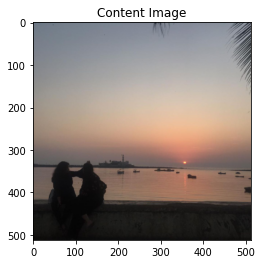

In [ ]:
#creating function to display the images
unloader = transforms.ToPILImage()  
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # clone tensor to avoid corrupting it
    image = image.squeeze(0)      # remove  fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
#gram matrix for style loss
def gram_matrix(input):
  batch_size, no_of_feature_maps,height_of_feature_map, breadth_of_feature_map = input.size()
  features = input.view(batch_size * no_of_feature_maps, height_of_feature_map * breadth_of_feature_map)

  G = torch.mm(features, features.t())

  return G.div(batch_size * no_of_feature_maps * height_of_feature_map * breadth_of_feature_map)



In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


####Above, we set it to eval because some layers have different behaviours during training and evaluation.

####Next, as VGG networks are trained on images with each channel being normalized by mean = [0.485, 0.456, 0.406] and standard deviation of [0.299, 0.224, 0.225]. We will also normalize our image this way before feeding it as network input.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1) #view is kinda like reshape in numpy, unless you dive into the technicalities of it.
        self.std = torch.tensor(std).view(-1, 1, 1) #passing -1 parameter to view function is us telling it to decide that dimension's parameters on its own.

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv layer
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

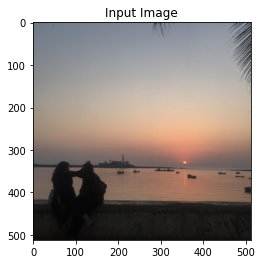

In [ ]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=1):
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correcting the values of updated input image (like clip in numpy)
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 0.762400 Content Loss: 9.623999

run [100]:
Style Loss : 0.673132 Content Loss: 9.425207

run [150]:
Style Loss : 0.572914 Content Loss: 9.264099

run [200]:
Style Loss : 0.483631 Content Loss: 9.138758

run [250]:
Style Loss : 0.414153 Content Loss: 9.037281

run [300]:
Style Loss : 0.367940 Content Loss: 8.960523

run [350]:
Style Loss : 0.347391 Content Loss: 8.891757

run [400]:
Style Loss : 0.328618 Content Loss: 8.845280

run [450]:
Style Loss : 0.318466 Content Loss: 8.804889

run [500]:
Style Loss : 0.318497 Content Loss: 8.767836



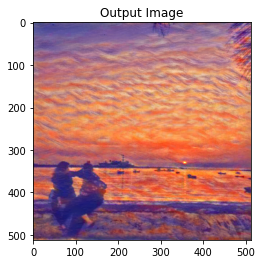

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()